# Udacity Term 1 Project 4: Advanced Lane Finding

The purpose of the project is to detect the lanes from the video stream and shade the areas between the identified lanes.

The pipeline used to detect lanes is as follows:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
#Section 0: Basic Imports
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from imageio import imread

### Section 1: Compute the camera calibration matrix and distortion coefficients from chessboard images

This section contains the first item on the list: calibration matrix. This is done by using a collection of 20 checkerboard images taken at different orientations and distances to get an overall view of the camera under consideration. For this, we use '9 x 6' corner detectors. The `cv2.calibrateCamera` function is used to obtain the camera's matrix, distortion coefficients, rotation and translation vectors, etc.
Note: Some of the images don't appear in the display since the function `cv2.findChessboardCorners` is not able to detect the specified (9, 6) number of corners in both directions. 

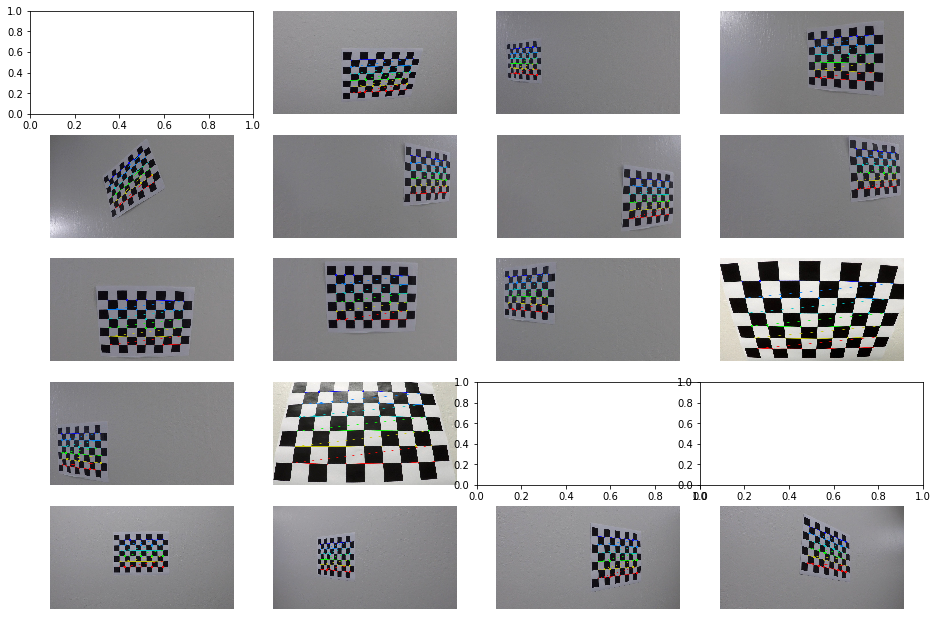

In [2]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

chess_dir = os.path.join(os.getcwd(), 'camera_cal')
chess_list = sorted(os.listdir(chess_dir))

nx = 9
ny = 6

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

img = imread(os.path.join(chess_dir, chess_list[0]))
img_size = (img.shape[1], img.shape[0])

# Make a list of calibration images
fig, axs = plt.subplots(5,4, figsize=(16, 11))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in range(len(chess_list)):
    img_name = os.path.join(chess_dir, chess_list[i])
    img = imread(img_name)

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ## Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    #
    ## If found, draw corners
    if ret == True:
        objpoints.append(objp)
        
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners2, ret)
        axs[i].axis('off')
        axs[i].imshow(img)
    
plt.show()
clret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

### Section 2: Apply a distortion correction to raw images
The `cv2.undistort` function is used here with the distorted image, the camera calibration matrix and distortion coefficients to undistort an image.

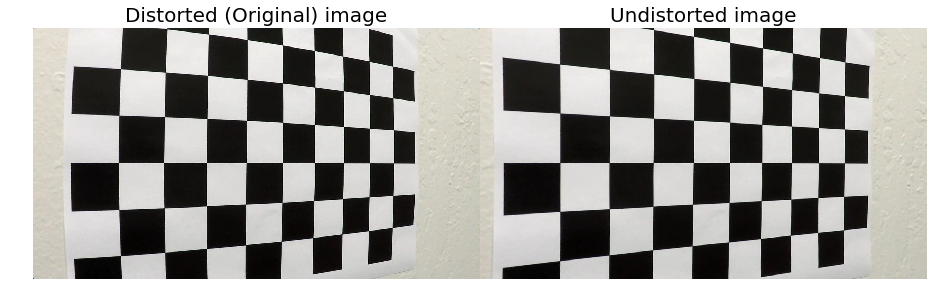

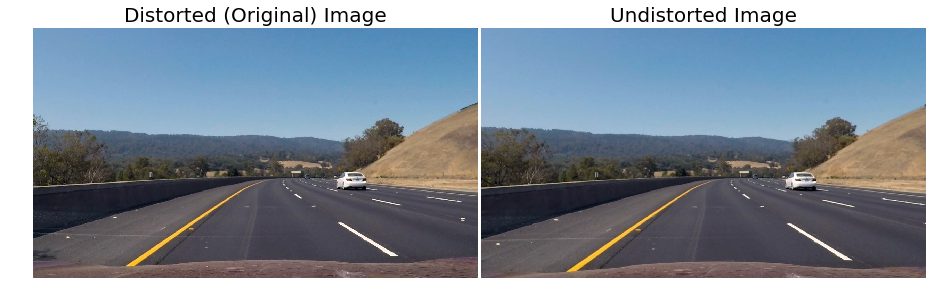

In [3]:
#Figures: 1 x CheckerboardCar, 1 x Test Images

fig, axs = plt.subplots(1,2, figsize=(16,11))
fig.subplots_adjust(hspace = .2, wspace=.001)

img = imread(os.path.join(chess_dir, chess_list[15]))
axs[0].axis('off')
axs[0].imshow(img)
axs[0].set_title('Distorted (Original) image', fontsize = 20)
dst = cv2.undistort(img, mtx, dist, None, mtx)
axs[1].axis('off')
axs[1].imshow(dst)
axs[1].set_title('Undistorted image', fontsize = 20)
plt.show()
## Test image

fig, axs = plt.subplots(1,2, figsize=(16,11))
fig.subplots_adjust(hspace = .2, wspace=.009)

img_test = imread(os.path.join(os.getcwd(), 'test_images/test3.jpg'))
axs[0].axis('off')
axs[0].imshow(img_test)
axs[0].set_title('Distorted (Original) Image', fontsize = 20)
img_undst = cv2.undistort(img_test, mtx, dist, None, mtx)
axs[1].axis('off')
axs[1].imshow(img_undst)
axs[1].set_title('Undistorted Image', fontsize = 20)
plt.show()

### Section 3 & 4: Use color transforms, gradients, etc., to create a thresholded binary image, Apply a perspective transform to rectify binary image ("birds-eye view")
As explained in the project section, sobel threshold and color thresholds was used. However, this caused a lot of fuss when it came to areas with shadows since the binary thresholded map had a lot of disturbance to isolate the lane lines. As a result, I used the L channel from the HLS space and B channel from the LAB space to obtain the final map instead of relying on sobel filter methods. 

Perspective transform is implemented in the `corners_unwarp` function and it takes the image under consideration as input alongisde the source and destination coordinates. I found it much better to hardcore the values rather than have them calculated programmatically since the coordinates stay pretty much the same with respect to the car's hood. 

In [4]:
# Section 3

def abs_sobel_thresh(img, orient='x', sobel_kernel = 3, thresh=(0,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def hls_threshl(img, thresh=(190, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    l_channel = l_channel * (255/np.max(l_channel))
    
    binary_output = np.zeros_like(l_channel)
    binary_output[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1
    return binary_output

def lab_threshb(img, thresh=(190,255)):
    # 1) Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))

    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    return binary_output

def img_pipeline(img, ksize = 7, hls_lth = (150,255), lab_bth = (150,255)):
    
    hls_binary = hls_threshl(img, thresh= hls_lth)
    lab_binary = lab_threshb(img, thresh= lab_bth)
    
    color_th = np.zeros_like(hls_binary)
    color_th[(hls_binary == 1) |  (lab_binary == 1)] = 1
    
    return color_th

In [5]:
# Section 4

def corners_unwarp(img, src, dst):
    h,w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

h,w = img_undst.shape[:2]

src = np.float32([(150+430,460), (1150-440,460), (150,720), (1150,720)])
dst = np.float32([(450,0), (w-450,0), (450,h), (w-450,h)])

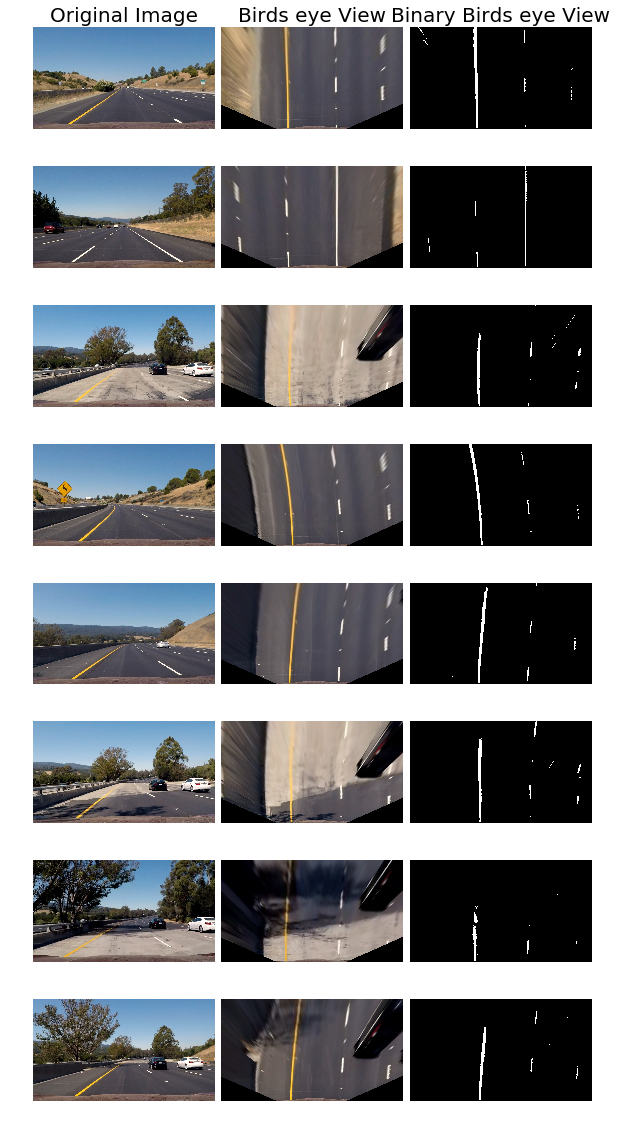

In [6]:
# Set up plot
image_list = os.listdir(os.path.join(os.getcwd(), 'test_images'))
fig, axs = plt.subplots(len(image_list),3, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.04)
axs = axs.ravel()
axs[0].set_title('Original Image', fontsize = 20)
axs[1].set_title('Birds eye View', fontsize = 20)
axs[2].set_title('Binary Birds eye View', fontsize = 20)                 
i = 0
for image in image_list:
    img = imread(os.path.join(os.getcwd(), 'test_images', image))
    img_undst = cv2.undistort(img, mtx, dist, None, mtx)
    img_unwarp, M, Minv = corners_unwarp(img_undst, src, dst)
    color_th_img_undst = img_pipeline(img_unwarp, hls_lth = (220,255), lab_bth = (190,255))
    #img_bin, Minv = pipeline(img)
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_unwarp, cmap='gray')
    axs[i].axis('off')
    i += 1
    axs[i].imshow(color_th_img_undst, cmap='gray')
    axs[i].axis('off')
    i += 1
plt.show()

### Section 5: Detect lane pixels and fit to find the lane boundary
There are two different functions implemented in this section: `polyfit_lanes` and `polyfit_lanes2`. The first function is used to identify the lane lines using sliding windows technique and the second function improves on the first one assuming the lanes are already known. The first function works by computing a histogram of the bottom half of the image and then using the sliding window to work the way to the top. The histogram gives a base point for the left and right lanes and this area is further restricted to quarter of the region around the histogram's midpoint to ensure that other lane lines do not interfere. 
The `polyfit_lanes2` function works assuming a previous fit is known and searches only around the range of that fit. 

In [9]:
# Define method to fit polynomial to binary image with lines extracted, using sliding window
def polyfit_lanes(img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    quarter_point = np.int(midpoint//2)
    # Previously the left/right base was the max of the left/right half of the histogram
    # this changes it so that only a quarter of the histogram (directly to the left/right) is considered
    # Courtesy: https://github.com/jeremy-shannon/CarND-Advanced-Lane-Lines
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data for visualization
    rectangle_data = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, rectangle_data

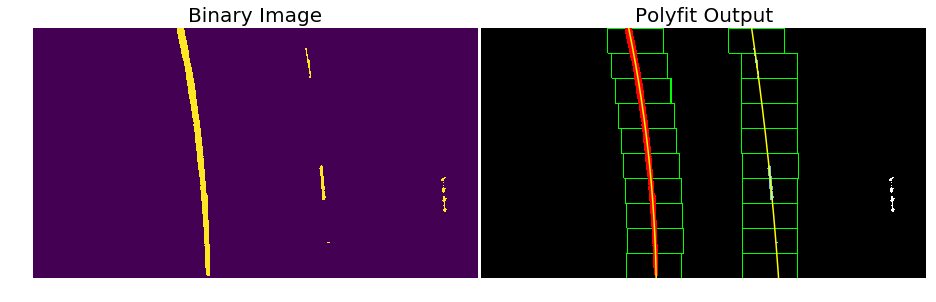

In [10]:
img = imread(os.path.join(os.getcwd(), 'test_images', 'test2.jpg'))
img_undst = cv2.undistort(img, mtx, dist, None, mtx)
img_unwarp, M, Minv = corners_unwarp(img_undst, src, dst)
img_bin = img_pipeline(img_unwarp, hls_lth = (220,255), lab_bth = (190,255))

left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles = polyfit_lanes(img_bin)

h = img_bin.shape[0]
left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
#print('fit x-intercepts:', left_fit_x_int, right_fit_x_int)

# Create an output image to draw on and  visualize the result
out_img = np.uint8(np.dstack((img_bin, img_bin, img_bin))*255)
# Generate x and y values for plotting
ploty = np.linspace(0, img_bin.shape[0]-1, img_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
for rect in rectangles:
# Draw the windows on the visualization image
    cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
    cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 
# Identify the x and y positions of all nonzero pixels in the image
nonzero = img_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]

fig, axs = plt.subplots(1,2, figsize=(16,11))
fig.subplots_adjust(hspace = .2, wspace=.009)

axs[0].axis('off')
axs[0].imshow(img_bin)
axs[0].set_title('Binary Image', fontsize = 20)
axs[1].axis('off')
axs[1].imshow(out_img)
axs[1].plot(left_fitx, ploty, color='yellow')
axs[1].plot(right_fitx, ploty, color='yellow')
axs[1].set_title('Polyfit Output', fontsize = 20)
plt.show()

In [11]:
def polyfit_lanes2(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds

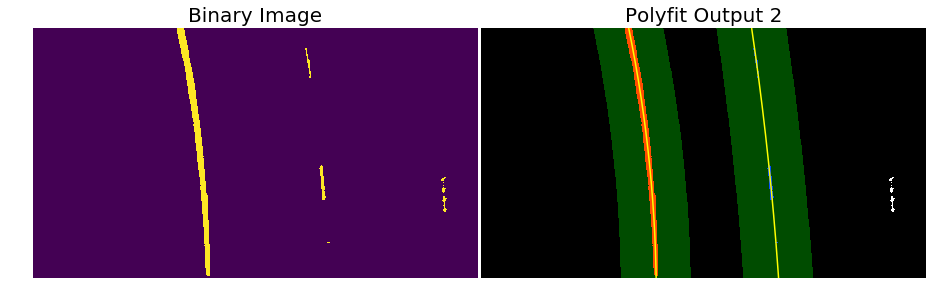

In [12]:
# visualize the result on example image
margin = 100

left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = polyfit_lanes2(img_bin, left_fit, right_fit)

# Generate x and y values for plotting
ploty = np.linspace(0, img_bin.shape[0]-1, img_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
left_fitx2 = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
right_fitx2 = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]

# Create an image to draw on and an image to show the selection window
out_img = np.uint8(np.dstack((img_bin, img_bin, img_bin))*255)
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
nonzero = img_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area (OLD FIT)
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

fig, axs = plt.subplots(1,2, figsize=(16,11))
fig.subplots_adjust(hspace = .2, wspace=.009)

axs[0].axis('off')
axs[0].imshow(img_bin)
axs[0].set_title('Binary Image', fontsize = 20)
axs[1].axis('off')
axs[1].imshow(result)
axs[1].plot(left_fitx, ploty, color='yellow')
axs[1].plot(right_fitx, ploty, color='yellow')
axs[1].set_title('Polyfit Output 2', fontsize = 20)
plt.show()

### Section 6: Determine the curvature of the lane and vehicle position with respect to center
The radius of curvature has been formulated as per the directions given in the project description, converting from pixel space to real world space by following U.S. regulation measures. The vehicle position with respect to the center are computed by assuming the car position to be at half the image resolution and then calculating the x intercepts of the left and right fits and averaging to get the lane center position. The center distance is then the difference between the lane center position and the car position and compensating in pixel space to real world space. 

In [13]:
# Method to determine radius of curvature and distance from lane center 
# based on binary image, polynomial fit, and L and R lane pixel indices
def measure_curvature_and_center_dist(thresh_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.048/100 # meters per pixel in y dimension
    xm_per_pix = 3.7/378 # meters per pixel in x dimension
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    h = thresh_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = thresh_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
        # print(left_curverad, 'm', right_curverad, 'm')
        # Example values: 632.1 m    626.2 m
    if r_fit is not None and l_fit is not None:
        car_position = thresh_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix    

    return left_curverad, right_curverad, center_dist

In [14]:
rad_l, rad_r, center_dist = measure_curvature_and_center_dist(img_bin, left_fit2, right_fit2, left_lane_inds2, right_lane_inds2)

print('Radius of curvature for example:', rad_l, 'm,', rad_r, 'm')
print('Distance from lane center', abs(center_dist), 'm')

Radius of curvature for example: 360.164651005 m, 872.921517337 m
Distance from lane center 0.380873049017 m


### Section 7 & 8: Warp the detected lane boundaries back onto the original image, Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position
Once I had a good measurement of the line positions in warped space, I then projected the measurements back onto the original iamge by using the `draw_lane` function. A polygon is generated based on plots from the fits, warped back to the perspective of the original image using the inverse perspective matrix `Minv` and overlaid onto the original image for display. An added flag determines if the information about the curvature and distance from center is to be displayed or not on the image itself. 

In [15]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv, rad_l, rad_r, center_dist, disp = False):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, 719, 720)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,0), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,0,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (original_img.shape[1], original_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.3, 0)
    
    if disp == True:
        new_img = result
        curv_rad = (rad_l + rad_r)/2.0
        font = cv2.FONT_HERSHEY_DUPLEX
        text = 'Radius of curvature: ' + '{:04.2f}'.format(curv_rad) + ' m'
        cv2.putText(new_img, text, (40,70), font, 1.5, (255,255,155), 2, cv2.LINE_AA)
        text = 'Distance from lane center: ' + '{:04.3f}'.format(abs(center_dist)) + ' m '
        cv2.putText(new_img, text, (40,120), font, 1.5, (255,255,155), 2, cv2.LINE_AA)
    return result

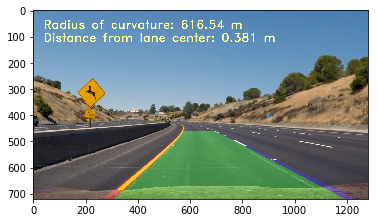

In [16]:
eg_img = draw_lane(img, img_bin, left_fit, right_fit, Minv, rad_l, rad_r, center_dist, disp = True)
plt.imshow(eg_img)
plt.show()